# NLP

## Import libraries

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import regex as re
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from pickle import dump

## Import Data

In [190]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv"

total_data = pd.read_csv(url, sep=",")

# Save data
total_data.to_csv("/workspaces/nlp_proyect/data/raw/url_spam.csv")

In [191]:
total_data

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True
...,...,...
2994,https://www.smartcitiesworld.net/news/news/dee...,False
2995,https://www.youtube.com/watch,True
2996,https://techcrunch.com/2019/07/04/an-optimisti...,False
2997,https://www.technologyreview.com/2019/12/20/13...,False


In [192]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


## Data Clean

In [193]:
# Count duplicated rows
count_duplicated = total_data.duplicated().sum()
count_duplicated

630

In [194]:
# Drop duplicated rows
total_data.drop_duplicates(inplace= True)

In [195]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2369 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2369 non-null   object
 1   is_spam  2369 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 39.3+ KB


In [196]:
# Categorical to numerical transformation
factorize_data = pd.factorize(total_data["is_spam"])
factorize_data

(array([0, 0, 0, ..., 1, 1, 1]), Index([True, False], dtype='bool'))

In [197]:
# Change with numerical values
total_data["is_spam"] = factorize_data[0]

In [198]:
total_data

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,0
1,https://www.hvper.com/,0
2,https://briefingday.com/m/v4n3i4f3,0
3,https://briefingday.com/n/20200618/m#commentform,1
4,https://briefingday.com/fan,0
...,...,...
2993,https://www.theverge.com/2020/6/29/21306889/di...,1
2994,https://www.smartcitiesworld.net/news/news/dee...,1
2996,https://techcrunch.com/2019/07/04/an-optimisti...,1
2997,https://www.technologyreview.com/2019/12/20/13...,1


In [199]:
# Count of each class
print(total_data.shape)
print(f"Spam: {len(total_data.loc[total_data.is_spam == 0])}")
print(f"No spam: {len(total_data.loc[total_data.is_spam == 1])}")

(2369, 2)
Spam: 244
No spam: 2125


### Text processing

In [200]:
def preprocess_text(text):
    # Remove any character that is not a letter (a-z) or white space ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Remove white spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Multiple white spaces into one
    text = re.sub(r'\s+', " ", text.lower())

    # Remove tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

# Applying a function to preprocess the text
total_data["url"] = total_data["url"].apply(preprocess_text)
total_data.head()

,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",0
1,"[https, www, hvper, com]",0
2,"[https, briefingday, com, v, i]",0
3,"[https, briefingday, com, m, commentform]",1
4,"[https, briefingday, com, fan]",0


In [201]:
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

# lemmatization of the text function
def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    tokens = [word for word in tokens if word != "http"]
    
    return tokens

# Applying a function to lemmatize the text
total_data["url"] = total_data["url"].apply(lemmatize_text)
total_data.head()

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,url,is_spam
0,"[briefingday, list, manage, unsubscribe]",0
1,[hvper],0
2,[briefingday],0
3,"[briefingday, commentform]",1
4,[briefingday],0


In [202]:
total_data.to_csv("/workspaces/nlp_proyect/data/processed/url_spam.csv")

## Word cloud

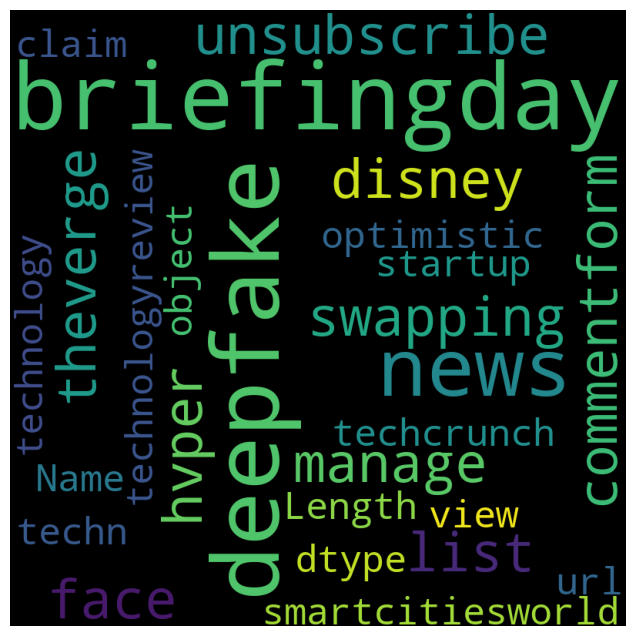

In [203]:
wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 24)\
    .generate(str(total_data["url"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [204]:
tokens_list = total_data["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

# text list to numerical list transformation
vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = total_data["is_spam"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [205]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 24)

X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## SVC MODEL

In [206]:
# Create model
model = SVC(random_state = 24)
model.fit(X_train, y_train)

# Save model
dump(model, open("/workspaces/nlp_proyect/models/model_nlp.pk", "wb"))

In [207]:
# Predict Train data
y_pred = model.predict(X_train)
y_pred

array([1, 1, 1, ..., 0, 1, 1])

In [208]:
# Predict Test data
y_pred_test = model.predict(X_test)
y_pred_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Train

In [209]:
accuracy_score(y_train, y_pred)

0.950395778364116

### Test

In [210]:
accuracy_score(y_test, y_pred_test)

0.9493670886075949

### Confusion matrix

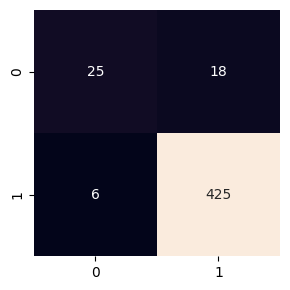

In [211]:
cm = confusion_matrix(y_test, y_pred_test)

cm_df = pd.DataFrame(cm)

plt.figure(figsize = (3, 3))
sns.heatmap(cm_df, annot=True, fmt="d", cbar=False)

plt.tight_layout()

plt.show()

### Optimizing the model

In [212]:
hyperparams = {
    "C": [0.01, 0.1, 1, 10, 100],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"],
    "degree": [2, 3, 4, 5, 6, 7],
    "class_weight": [None, 'balanced', {0: 1, 1: 2}],
    "random_state": [24]
}

In [213]:
# ParameterGrid search
accs = []
for combination in ParameterGrid(hyperparams):
    model = SVC(**combination)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    accs.append(accuracy_score(y_train, y_pred))

best_acc = max(accs)
best_combination = list(ParameterGrid(hyperparams))[accs.index(best_acc)]
best_model = SVC(**best_combination)
best_model.fit(X_train, y_train)

# Save model
dump(best_model, open("/workspaces/nlp_proyect/models/best_model_nlp.pk", "wb"))

best_combination

{'C': 1,
 'class_weight': None,
 'degree': 5,
 'gamma': 'scale',
 'kernel': 'poly',
 'random_state': 24}

### Train

In [214]:
best_acc

0.9641160949868074

In [215]:
y_pred_test = best_model.predict(X_test)

### Test

In [216]:
accuracy_score(y_test, y_pred_test)

0.9493670886075949

### Confusion matrix

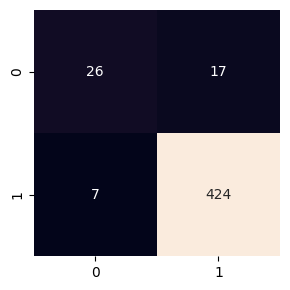

In [217]:
cm = confusion_matrix(y_test, y_pred_test)

cm_df = pd.DataFrame(cm)

plt.figure(figsize = (3, 3))
sns.heatmap(cm_df, annot=True, fmt="d", cbar=False)

plt.tight_layout()

plt.show()